# Centralised Multi Layer Perceptron

- Import nessecary libraries and frameworks
- Data pre-processing
- Multi Layer Perceptron

In [1]:
import warnings
import syft as sy
import numpy as np 
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

import torch as th
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Hook that extends the Pytorch library to enable all computations with pointers of tensors sent to other workers
hook = sy.TorchHook(th)

## Pre-processing the data

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

# Feature scaling 
df['normalizedAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'], axis=1)
df = df.drop(['Time'], axis=1)

# Split the data into training and test set
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']

# Splitting the data into train:test:validation as follows 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_val.shape)

(170883, 29)
(56962, 29)
(56962, 1)


Turning the data into PyTorch format

In [4]:
# Converting to PyTorch tensors
y_train_tensor = th.tensor(y_train.values).float()
X_train_tensor = th.tensor(X_train.values).float()
y_test_tensor = th.tensor(y_test.values).float()
X_test_tensor = th.tensor(X_test.values).float()
y_val_tensor = th.tensor(y_val.values).float()
X_val_tensor = th.tensor(X_val.values).float()

# Converting to tensor dataset
train = TensorDataset(X_train_tensor, y_train_tensor)
test = TensorDataset(X_test_tensor, y_test_tensor)
val = TensorDataset(X_val_tensor, y_val_tensor)

# Converting to dataloaders 
# (, drop_last=True)
train_loader = DataLoader(train, batch_size=256)

test_loader = DataLoader(test, batch_size=32)
val_loader = DataLoader(val, batch_size = 32)

In [5]:
# See that train:test:val all contains fraudulent and non-fraudulent transactions
print('Train set: ', Counter(y_train['Class']))
print('Test set: ', Counter(y_test['Class']))
print('Validation set: ', Counter(y_val['Class']))

Train set:  Counter({0: 170567, 1: 316})
Test set:  Counter({0: 56864, 1: 98})
Validation set:  Counter({0: 56884, 1: 78})


# MLP
- Train the model
- Validation set
    - Prediction
    - AUPCR curve
    - Confusion matrix 

- Test set
    - Prediction
    - AUPCR curve
    - Confusion matrix 

### Creating the model and evaluation

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Linear(29,15)
        self.hidden = nn.Linear(15,15)
        self.output = nn.Linear(15, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = th.sigmoid(self.output(x))
        return x

### Functions to train and validate/test the model

In [8]:
def training(model, optimizer, epochs, loader, train_loader, y, X_tensor):
    """ Train the MLP model.
    IN: optimizer, epochs (int), loader (data loader), train_loader (data loader), y (validation or test), X_tensor (validation or test)
    OUT: -
    """
    nbr_epochs = 0
    
    for e in range(epochs):
        running_loss = 0
        nbr_epochs += 1
        
        for x_load, y_load in train_loader:

            # TODO: Training pass
            optimizer.zero_grad()
            output = model.forward(x_load)
            loss = criterion(output, y_load)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        #else:
         #   print(f"Training loss: {running_loss/len(loader)}")
        
        # Evaluate the model after every n:th epoch
        if nbr_epochs % 10 == 0:
            print('Epoch: ', nbr_epochs)
            prediciton_model(model, y, loader, X_tensor)
            

In [9]:
def prediciton_model(model, y, loader, X_tensor):
    """ Test the model on the validation set every 10:th epoch.
    IN: model, y (dataframe: either test- or validationset), loader (either test- or validation), 
    X_tensor (tensor for either test- or validation)
    OUT: - 
    """
    probabilities = loss_prob_model(model, loader, X_tensor)
    
    y_pred = th.cat(probabilities)
    y_pred_numpy = y_pred.detach().numpy() 
    y_pred_binary = (y_pred_numpy > 0.5)
    
    aupcr = average_precision_score(y, y_pred_numpy)
    
    print('AUPCR score: ' + str(aupcr))
    
    cm = confusion_matrix(y, y_pred_binary)
    print(cm)

In [10]:
def loss_prob_model(model, loader, X_tensor):
    """ Computes the loss and probabilities in order to compute the AUPCR score.
    IN: model, loader (either test- or validation), X_tensor (tensor for either test- or validation)
    OUT: output_list (a list of probabilities)
    """
    model.eval()
    loss = 0
    output_list =[]
    
    for data, target in loader:
        output = model(data)
        loss += F.binary_cross_entropy(output, target, reduction='sum').item()
        output_list.append(output)
    loss /= len(X_tensor)
    print('Average loss: {:.8f}'.format(loss))
    return output_list

In [11]:
def aupcr_score(y, y_pred_numpy):
    """ Computes the AUPCR score and illustrates it in a plot.
    IN: y (array), y_pred_numpy (numpy array)
    OUT:
    """
    fpr, tpr, threshold = metrics.precision_recall_curve(y, y_pred_numpy)
    aupcr = average_precision_score(y, y_pred_numpy)
    print('AUPCR score: ' + str(aupcr))
    
    plt.title('Area under Profile Curve ratio (AUPCR)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % aupcr)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    #plt.savefig('name_to_save_fig_under.png')
    plt.show()

In [12]:
def conf_matrix(y, y_pred_num_bin):
    """ Prints the confusion matrix, [TN, FP; FN, TP]
    IN: y (array), y_pred_num_bin (binary numpy array)
    OUT: -
    """
    cm = confusion_matrix(y_test, y_pred_num_bin)
    print(cm)

### Train the model

In [13]:
model = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

training(model, optimizer, 80, val_loader, train_loader, y_val, X_val_tensor)

Epoch:  10
Average loss: 0.00287717
AUPCR score: 0.7346522899528023
[[56878     6]
 [   28    50]]
Epoch:  20
Average loss: 0.00245561
AUPCR score: 0.7659873132652676
[[56877     7]
 [   20    58]]
Epoch:  30
Average loss: 0.00226714
AUPCR score: 0.7831586892522133
[[56877     7]
 [   16    62]]
Epoch:  40
Average loss: 0.00213749
AUPCR score: 0.7968752025232331
[[56878     6]
 [   15    63]]
Epoch:  50
Average loss: 0.00203742
AUPCR score: 0.809002044373039
[[56877     7]
 [   15    63]]
Epoch:  60
Average loss: 0.00195323
AUPCR score: 0.8187035232310428
[[56876     8]
 [   15    63]]
Epoch:  70
Average loss: 0.00184853
AUPCR score: 0.8315302689094806
[[56876     8]
 [   15    63]]
Epoch:  80
Average loss: 0.00175983
AUPCR score: 0.8400523068731851
[[56876     8]
 [   14    64]]


### Validation set

In [36]:
# Predict the model on the test set
pred_val = loss_prob_model(model, val_loader, X_val_tensor) 

# Concatenate pred_test
y_pred_val = th.cat(pred_val)

# Convert y_pred_test to a numpy array
y_pred_val_num = y_pred_val.detach().numpy() 

# Making the array binary
y_pred_num_val_bin = (y_pred_val_num > 0.5)

Average loss: 0.00640666


#### Area under Profile Curve ratio (AUPCR) 

AUPCR score: 0.6748466316852488


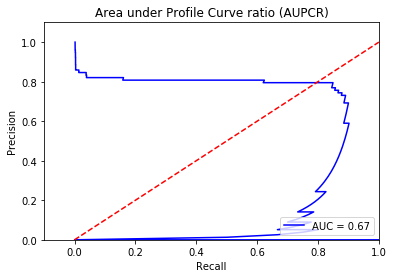

In [37]:
aupcr_score(y_val, y_pred_val_num)

#### Confusion matrix

In [ ]:
conf_matrix(y_val, y_pred_num_val_bin)

### Test set

In [ ]:
# Predict the model on the test set
pred_test = loss_prob_model(model, test_loader, X_test_tensor) 

# Concatenate pred_test
y_pred_test = th.cat(pred_test)

# Convert y_pred_test to a numpy array
y_pred_test_num = y_pred_test.detach().numpy() 

# Making the array binary
y_pred_num_test_bin = (y_pred_test_num > 0.5)

#### Area under Profile Curve ratio (AUPCR) 

In [ ]:
aupcr_score(y_test, y_pred_test_num)

#### Confusion matrix

In [ ]:
conf_matrix(y_test, y_pred_num_test_bin)